In [ ]:
%pip install matplotlib seaborn scipy

# Funciones de utilidades

In [1]:
import os
from pathlib import Path
import tkinter as tk
from tkinter import Tk, messagebox, filedialog
import pandas as pd

def popup(message, title=None):
    root = Tk()
    root.withdraw()
    root.wm_attributes("-topmost", 1)
    messagebox.showinfo(title, message, parent=root, default="ok")
    root.destroy()

def seleccionar_archivo_xlsx(msg:str = "Seleccionar archivos xlsx")-> list[Path]:
    # Crear la ventana de selección de archivo
    root = tk.Tk()
    root.withdraw()
    root.overrideredirect(True)
    root.geometry('0x0+0+0')
    root.deiconify()
    root.lift()
    root.focus_force()
    root.attributes('-alpha', 0.0)
    # Window mantain in front of everything
    root.attributes('-topmost', True)
    
    file_paths = filedialog.askopenfilenames(
        parent=root,
        title=msg,
        filetypes=[("Excel files", "*.xlsx *.xls")]
    )
    root.destroy()
    if len(file_paths) == 0:
        raise Exception("No se ha selecciondo un archivo excel")
    return list(Path(file) for file in file_paths)

# Cargar archivo con formato tidy

In [108]:
path:Path = Path(seleccionar_archivo_xlsx(msg="Seleccione el archivo que contiene los registros en formato tidy")[0])
df = pd.read_excel(path)
df_raw = df.copy() #Copia de seguridad del archivo por si se modifica mas adelante
print(f"Columns: {df.columns}\nSize: {df.shape}")
df.head(3)

Columns: Index(['model', 'temperature', 'prompt_id', 'file_id', 'question_number',
       'correct', 'llm_answer', 'completion_tokens', 'prompt_tokens',
       'exec_time'],
      dtype='object')
Size: (14400, 10)


,model,temperature,prompt_id,file_id,question_number,correct,llm_answer,completion_tokens,prompt_tokens,exec_time
0,llama3_70b,0,0,1,1,1,b,103,90,1.2062
1,llama3_70b,0,0,1,3,1,b,90,98,1.1170
2,llama3_70b,0,0,1,7,1,d,117,233,1.0395


In [5]:
print(df.describe())
print(
    df.groupby(["prompt_id"]).agg(
        accuracy= ("correct", "mean"),
        completion_tokens_mean= ("completion_tokens", "mean"),
        prompt_tokens_mean= ("prompt_tokens", "mean"),
        exec_time_mean= ("exec_time", "mean"),
    ).reset_index()
)

        temperature     prompt_id       file_id  question_number  \
count  14400.000000  14400.000000  14400.000000     14400.000000   
mean       0.500000      1.500000     15.500000        32.933333   
std        0.500017      1.118073      8.655742        18.343544   
min        0.000000      0.000000      1.000000         1.000000   
25%        0.000000      0.750000      8.000000        19.000000   
50%        0.500000      1.500000     15.500000        30.500000   
75%        1.000000      2.250000     23.000000        49.000000   
max        1.000000      3.000000     30.000000        64.000000   

            correct  completion_tokens  prompt_tokens     exec_time  
count  14400.000000       14400.000000   14400.000000  14400.000000  
mean       0.691875         225.600000     551.075000      6.089467  
std        0.461735         121.165005     376.485773      6.845276  
min        0.000000           6.000000      90.000000      0.319600  
25%        0.000000         142.00000

# Configuracion de estilos

In [125]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo para gráficos profesionales
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.figsize': (20, 12),
    'axes.titlepad': 20,
    'axes.labelpad': 10,
    'legend.title_fontsize': 14
})

LLAMA3_COLOR = "#009ADE"
MIXTRAL_COLOR = "#F28522"
COLOR_MAP = 'RdYlGn'

BASE_COLOR_MAP = {
    "llama3_70b": "#009ADE",
    "mixtral_8x7b": "#F28522",
    "phi3_mini": "purple",
    "mixtral_8x22b": "#ba5b04",
    "chatgpt_3.5_turbo": "teal"
}

## Gráfica Rendimiento General (IC) 

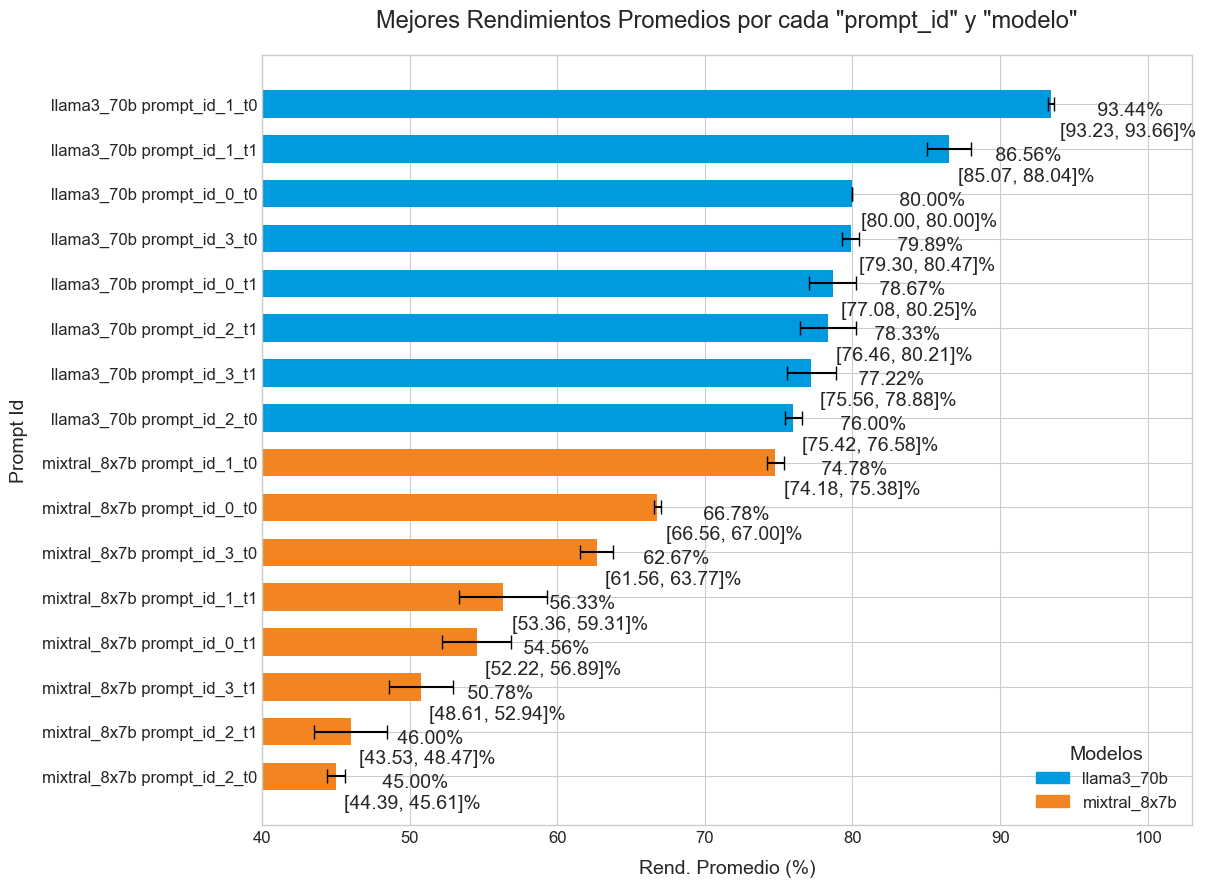

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import random

# Asumiendo que df_all es tu DataFrame
df_dummy = df.copy()
df_dummy["unique_label"] = df_dummy.apply(
    lambda row: f"{row['model']} prompt_id_{int(row['prompt_id'])}_t{int(row['temperature'])}", axis=1
)

# Agrupar por 'prompt_id_combined' y 'file_num' y calcular la precisión
accuracy_df = df_dummy.groupby(['unique_label', 'file_id']).agg(
    accuracy=('correct', 'mean')
).reset_index()

# Calcular la media y el error estándar de la precisión por 'prompt_id'
summary_df = accuracy_df.groupby('unique_label').agg(
    mean_accuracy=('accuracy', 'mean'),
    std_accuracy=('accuracy', 'std'),
    count=('accuracy', 'count')
).reset_index()
summary_df = summary_df.rename(
    columns={
        'mean_accuracy': 'accuracy',
        'std_accuracy': 'std',
        })

confidence_level = 0.95
z_value = stats.norm.ppf((1 + confidence_level) / 2)
N = 30
summary_df["ci"] = z_value * summary_df["std"]/np.sqrt(N)
summary_df['ci_lower'] = summary_df['accuracy'] - summary_df["ci"]
summary_df['ci_upper'] = summary_df['accuracy'] + summary_df["ci"]

# Ordenamos por exactitud de mayor a menor
summary_df = summary_df.sort_values(by='accuracy', ascending=False)

# Definir colores específicos para ciertos modelos
color_map = BASE_COLOR_MAP # type: ignore
# Extraer modelos únicos
models = df_dummy['model'].unique()

# Generar colores aleatorios para modelos no especificados
for model in models:
    if model not in color_map:
        color_map[model] = f"#{random.randint(0, 0xFFFFFF):06x}"

# Crear una lista de colores basada en el modelo de cada barra
bar_colors = [color_map[label.split()[0]] for label in summary_df['unique_label']]

y_positions = np.arange(len(summary_df)) * 1.3 
plt.figure(figsize=(12, 10))
bars = plt.barh(y_positions, summary_df['accuracy']*100, xerr=(summary_df['ci_upper'] - summary_df['accuracy'])*100, capsize=5, color=bar_colors)

# Añadir las etiquetas de exactitud a las barras
for bar, lower, upper in zip(bars, summary_df['ci_lower'], summary_df['ci_upper']):
    plt.text(
        bar.get_width() + 5.2, 
        bar.get_y() + bar.get_height() / 2 + 0.49, 
        f' {bar.get_width():.2f}%\n[{lower*100:.2f}, {upper*100:.2f}]%', 
        ha='center', 
        va='center'
    )

# Configuración de etiquetas y título
plt.xlabel('Rend. Promedio (%)')
plt.xlim([40,103])
plt.yticks(y_positions, summary_df['unique_label'])
plt.ylabel('Prompt Id')
plt.title('Mejores Rendimientos Promedios por cada "prompt_id" y "modelo"', fontsize=17)
plt.gca().invert_yaxis()

# Agregar leyenda
# legend_elements = [plt.Rectangle((0,0),1,1, color=color, label=model) for model, color in color_map.items()]
legend_elements = []
for model, color in color_map.items():
    if model in list(df["model"].unique()):
        legend_elements.append((model, color))
legend_elements = [plt.Rectangle((0,0),1,1, color=color, label=model) for model, color in legend_elements]
plt.legend(handles=legend_elements, title="Modelos", loc="lower right")

# Mostrar la gráfica
plt.show()

In [116]:
legend_elements = [plt.Rectangle((0,0),1,1, color=color, label=model) for model, color in color_map.items()]
legend_elements

## Errores

In [121]:
print(f"Available models: {df['model'].unique()}\n columns: {df.columns}")


Available models: ['llama3_70b' 'mixtral_8x7b']
 columns: Index(['model', 'temperature', 'prompt_id', 'file_id', 'question_number',
       'correct', 'llm_answer', 'completion_tokens', 'prompt_tokens',
       'exec_time'],
      dtype='object')


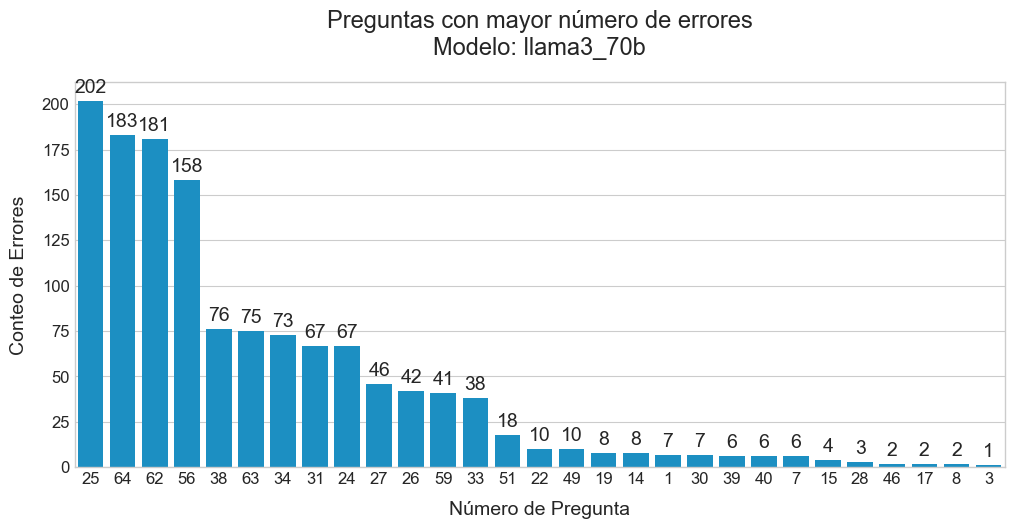

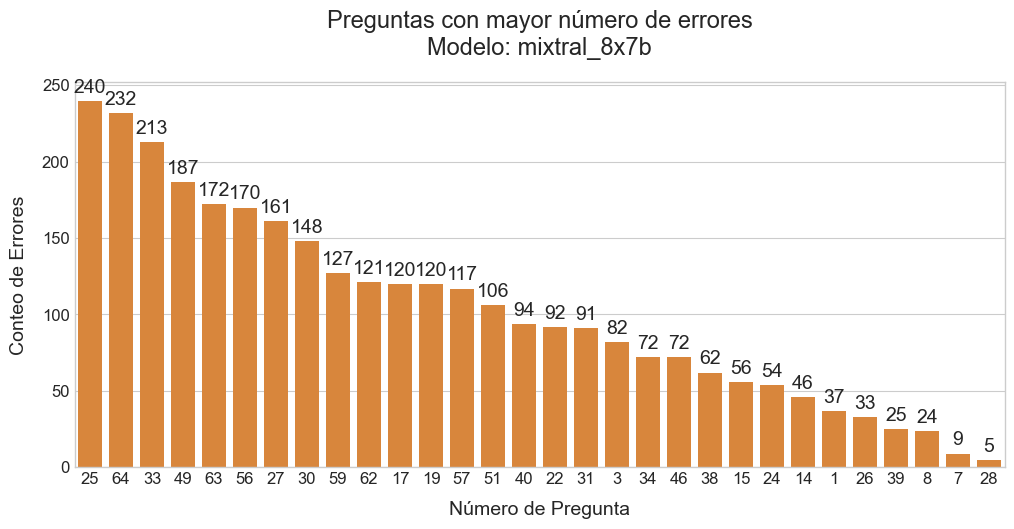

{'question_number': {10: 25,
  29: 64,
  16: 33,
  22: 49,
  28: 63,
  24: 56,
  12: 27,
  14: 30,
  26: 59,
  27: 62},
 'error_count': {10: 240,
  29: 232,
  16: 213,
  22: 187,
  28: 172,
  24: 170,
  12: 161,
  14: 148,
  26: 127,
  27: 121}}

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ---------- PARAMETROS -------------------
# MODELO = "llama3_70b" # mixtral_8x7b # phi3_mini #chatgpt_3.5_turbo #mixtral_8x22b #
CORRECTO = 0

# -----------------------------------------

for MODELO in df["model"].unique():
    # Calcular el número de errores por pregunta
    errors_by_question = df[
        (df['correct'] == CORRECTO) & 
        (df['model'] == MODELO)]\
        .groupby(['question_number']).size().reset_index(name='error_count')

    # print(errors_by_question)
    # Ordenar por el número de errores en orden descendente
    errors_by_question = errors_by_question.sort_values(by='error_count', ascending=False)
    errors_by_question["model"] = MODELO
    errors_by_question["question_number"] = errors_by_question["question_number"].astype(int)

    plt.figure(figsize=(12, 5))
    ax = sns.barplot(data=errors_by_question, x='question_number', y='error_count', order=errors_by_question['question_number'], color=BASE_COLOR_MAP[MODELO]) # type: ignore
    plt.title(f'Preguntas con mayor número de errores\nModelo: {MODELO}', fontsize=17)
    plt.xlabel('Número de Pregunta')
    plt.ylabel('Conteo de Errores')
    # plt.ylim([0,65])
    plt.xticks(rotation=0)

    # Añadir los valores encima de las barras con un pequeño espacio
    for container in ax.containers:
        ax.bar_label(container, label_type="edge", padding=3)

    plt.show()

# errors_by_question.to_clipboard()
# errors_by_question[["question_number", "error_count"]].head(10).to_dict()

## Mapas de Calor
El siguiente código genera un mapa de calor donde poder visualizar las preguntas que estuvieron correctas (1 verde) o incorrectas (0 rojo) para cada pregunta y archivo generado segun la configuración estipualada

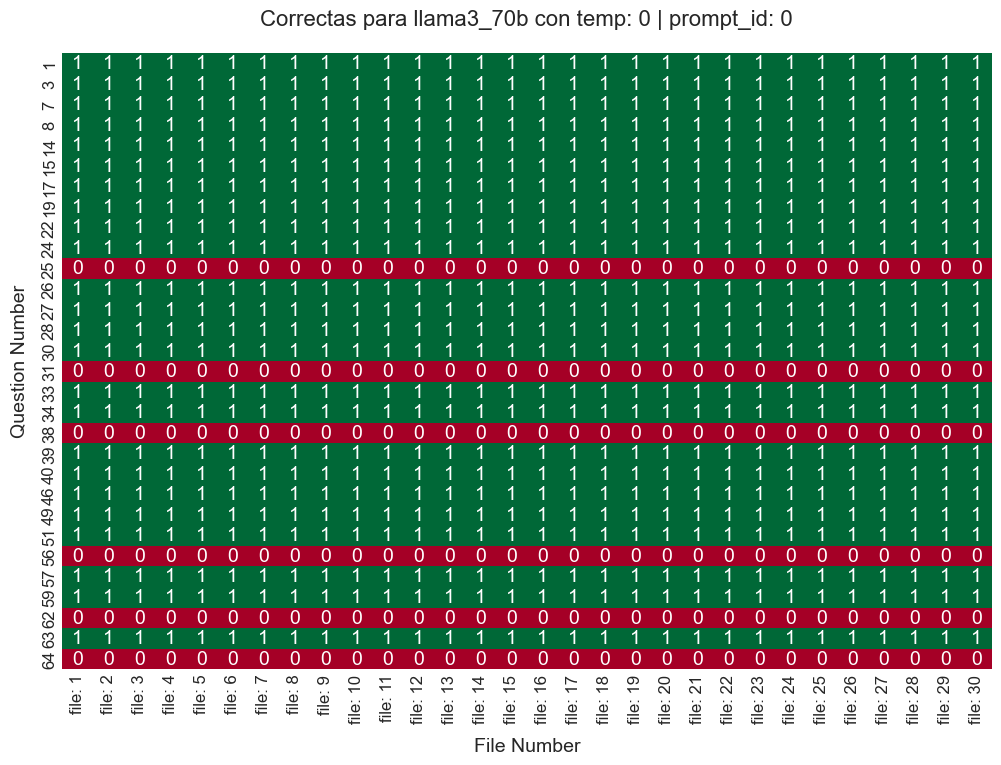

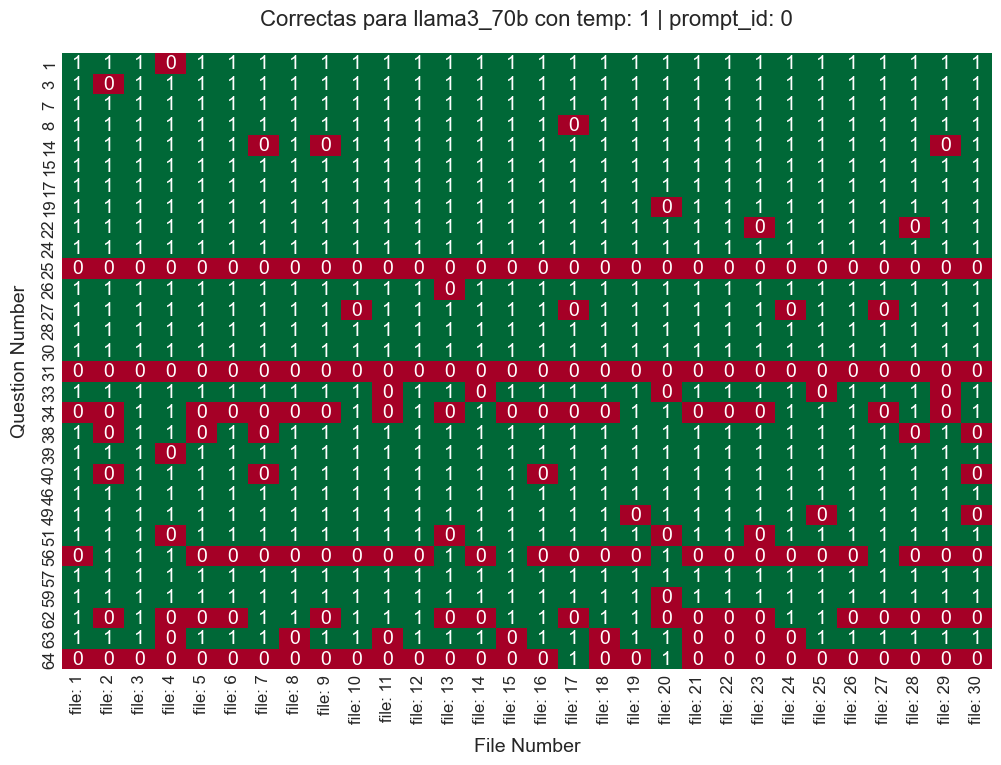

In [134]:
import pandas as pd
import seaborn as sns

#------- PARAMETROS CONFIGURACION GRÁFICA------------------------------------
selected_config = [
    {"model": "llama3_70b", "temperature": 0, "prompt_id": 0},
    {"model": "llama3_70b", "temperature": 1, "prompt_id": 0},
    ]

annot_config = True
# cbar_config = False
#----------------------------------------------------------------------------

for select_config in selected_config:
    model_selected =  select_config["model"]
    temperature_selected = select_config["temperature"]
    prompt_id_selected = select_config["prompt_id"]
    filtered_df = df[
        (df['model'] == model_selected) & 
        (df['temperature'] == temperature_selected) & 
        (df['prompt_id'] == prompt_id_selected)]

    # Hacer el pivot de los datos
    pivot_df = filtered_df.pivot(index='question_number', columns='file_id', values='correct')

    # Renombrar las columnas para que tengan el formato 'file_num=N'
    pivot_df.columns = [f'file: {col}' for col in pivot_df.columns]

    # Resetear el índice para tener 'question_num' como una columna
    pivot_df.reset_index(inplace=True)
    # Mostrar el DataFrame resultante
    # print(pivot_df.head(3))


    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_df.set_index('question_number'), annot=annot_config, cmap=COLOR_MAP, cbar=cbar_config) # type: ignore
    plt.title(f'Correctas para {model_selected} con temp: {temperature_selected} | prompt_id: {prompt_id_selected}')
    plt.xlabel('File Number')
    plt.ylabel('Question Number')
    plt.show()


## Relacion rendimiento, tokens generados y tokens de prompt

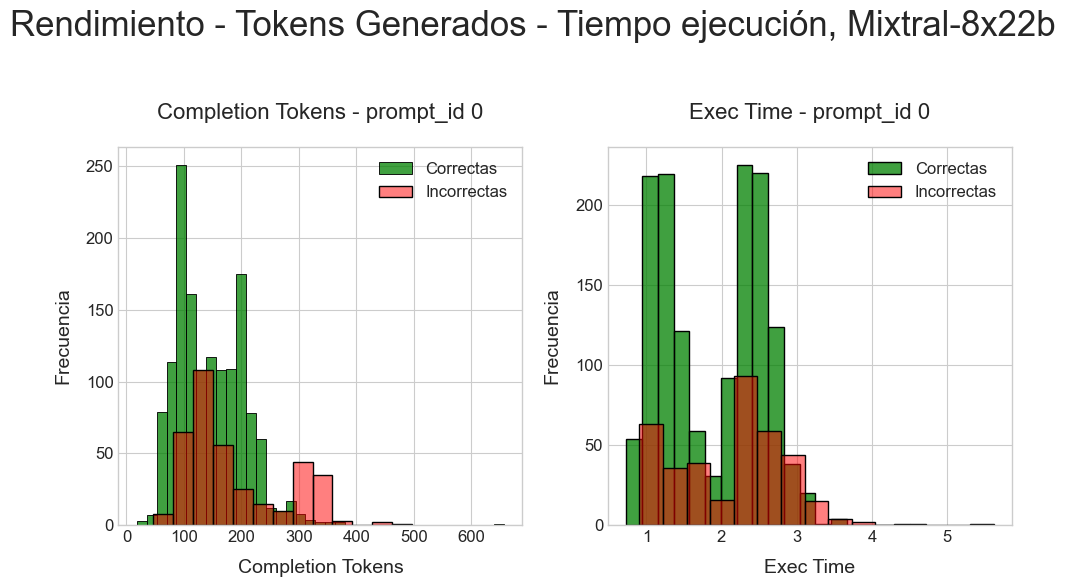

In [130]:
import matplotlib.pyplot as plt
import seaborn as sns

# ----------- PARAMETROS ----------------------------------
MODELO = "llama3_70b"
FIGURE_TITLE_SIZE = 25
FIGURE_TITLE = 'Rendimiento - Tokens Generados - Tiempo ejecución, Mixtral-8x22b'
# ----------------------------------------------------------

# Filtrar el DataFrame para el modelo específico y las columnas de interés
df_filtered = df[(df["model"] == MODELO)][["prompt_tokens", "completion_tokens", "exec_time", "prompt_id", "correct"]]

# Obtener el valor único de prompt_id
prompt_id = df_filtered["prompt_id"].unique()[0]

# Configurar el tamaño de la figura
fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=False)

# Filtrar el DataFrame para el prompt_id específico
df_prompt = df_filtered[df_filtered["prompt_id"] == prompt_id]

# Histograma para 'completion_tokens'
sns.histplot(df_prompt[df_prompt["correct"] == 1]["completion_tokens"], kde=False, color='green', label='Correctas', ax=axes[0])
sns.histplot(df_prompt[df_prompt["correct"] == 0]["completion_tokens"], kde=False, color='red', label='Incorrectas', ax=axes[0], alpha=0.5)
axes[0].set_title(f'Completion Tokens - prompt_id {prompt_id}')
axes[0].set_xlabel('Completion Tokens')
axes[0].set_ylabel('Frecuencia')
axes[0].legend()

# Histograma para 'exec_time'
sns.histplot(df_prompt[df_prompt["correct"] == 1]["exec_time"], kde=False, color='green', label='Correctas', ax=axes[1])
sns.histplot(df_prompt[df_prompt["correct"] == 0]["exec_time"], kde=False, color='red', label='Incorrectas', ax=axes[1], alpha=0.5)
axes[1].set_title(f'Exec Time - prompt_id {prompt_id}')
axes[1].set_xlabel('Exec Time')
axes[1].set_ylabel('Frecuencia')
axes[1].legend()

# Añadir título a la figura
fig.suptitle(FIGURE_TITLE, fontsize=FIGURE_TITLE_SIZE)

# Ajustar el layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Ditribucion de parametros

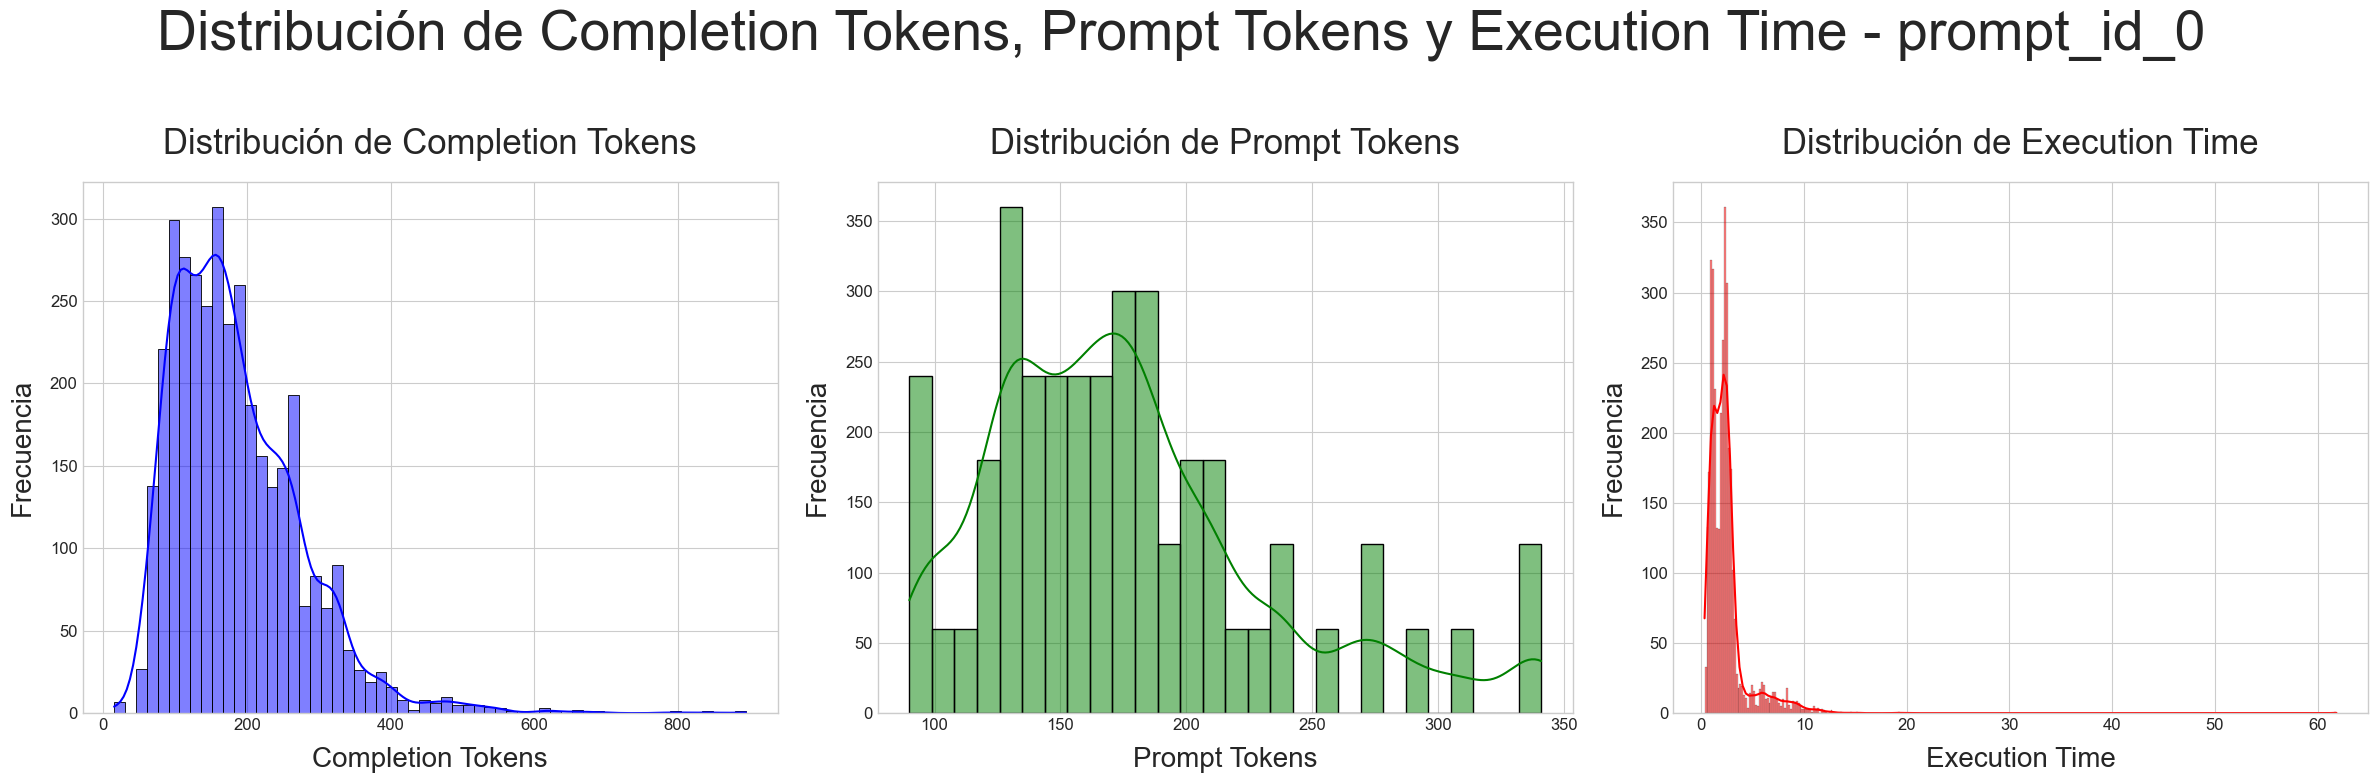

In [131]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm

# -------- PARAMETROS ----------------
FONTSIZE_SUBPLOTS = 25
LABELSSIZE_SUBPLOTS = 20

AUX_PROMPT_ID = 0
# -----------------------------------

# Figura 1: Distribución de completion_tokens, prompt_tokens y exec_time
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
df_copy = df.copy()
df_copy = df_copy[(df_copy["prompt_id"] == AUX_PROMPT_ID)]
# Histograma para 'completion_tokens'
sns.histplot(df_copy["completion_tokens"], kde=True, ax=axes[0], color='blue')
axes[0].set_title('Distribución de Completion Tokens', fontsize= FONTSIZE_SUBPLOTS)
axes[0].set_xlabel('Completion Tokens', fontsize=LABELSSIZE_SUBPLOTS)
axes[0].set_ylabel('Frecuencia', fontsize=LABELSSIZE_SUBPLOTS)

# Histograma para 'prompt_tokens'
sns.histplot(df_copy["prompt_tokens"], kde=True, ax=axes[1], color='green')
axes[1].set_title('Distribución de Prompt Tokens', fontsize= FONTSIZE_SUBPLOTS)
axes[1].set_xlabel('Prompt Tokens', fontsize=LABELSSIZE_SUBPLOTS)
axes[1].set_ylabel('Frecuencia', fontsize=LABELSSIZE_SUBPLOTS)

# Histograma para 'exec_time'
sns.histplot(df_copy["exec_time"], kde=True, ax=axes[2], color='red')
axes[2].set_title('Distribución de Execution Time', fontsize= FONTSIZE_SUBPLOTS)
axes[2].set_xlabel('Execution Time', fontsize=LABELSSIZE_SUBPLOTS)
axes[2].set_ylabel('Frecuencia', fontsize=LABELSSIZE_SUBPLOTS)

# Ajustar el layout
fig.suptitle(f'Distribución de Completion Tokens, Prompt Tokens y Execution Time - prompt_id_{AUX_PROMPT_ID} ', fontsize=40)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()